In [2]:
import os, json
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt
from rerank_outputs import load_and_merge_scores
from scipy.stats import spearmanr

with open("all_results_processed.json") as f:
    all_results = json.load(f)

/usr2/mingqia2/miniconda3/envs/hw2-dr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_results['metadata']

{'model': 'Qwen/Qwen3-4B',
 'eval_model': 'gpt-5-nano-2025-08-07',
 'sampling_params': {'n': 50, 'temperature': 0.2, 'max_tokens': 512},
 'total_questions': 100,
 'total_candidates': 5000,
 'dataset': 'infobench'}

In [3]:
len(all_results['results'])

100

In [4]:
all_results['results'][0].keys()

dict_keys(['question_id', 'prompt', 'question_data', 'candidates'])

In [5]:
len(all_results['results'][0]['candidates'])

50

In [8]:
all_results['results'][0]['candidates'][0].keys()

dict_keys(['candidate_id', 'generated_text', 'finish_reason', 'token_ids', 'generation_len', 'full_chat', 'scores'])

In [7]:
# TIP: use these "generated_text" fields to count unique generations for each infobench question
all_results['results'][0]['candidates'][0]['generated_text']

'Sure! Below is a Python code snippet that constructs a two-hidden layer feedforward neural network using PyTorch\'s `torch.nn` module. The network includes an input layer, two hidden layers with ReLU activation, and an output layer. The number of neurons in the hidden layers is chosen between 32 and 128 to maintain a reasonably sized network. Comments are included to clarify each step.\n\n```python\nimport torch\nimport torch.nn as nn\n\n# Define the neural network class\nclass TwoHiddenLayerNetwork(nn.Module):\n    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):\n        super(TwoHiddenLayerNetwork, self).__init__()\n        \n        # Input layer: input_size -> hidden_size1\n        self.layer1 = nn.Linear(input_size, hidden_size1)\n        \n        # Hidden layer 1: hidden_size1 -> hidden_size2\n        self.layer2 = nn.Linear(hidden_size1, hidden_size2)\n        \n        # Hidden layer 2: hidden_size2 -> output_size\n        self.layer3 = nn.Linear(hidd

In [ ]:
unique_counts = []
for res in all_results['results']:
    generated_texts = [cand['generated_text'] for cand in res['candidates']]
    num_unique = len(set(generated_texts))
    unique_counts.append(num_unique)  

In [9]:
mean_unique = np.mean(unique_counts)
median_unique = np.median(unique_counts)
std_unique = np.std(unique_counts)

print(f"Mean: {mean_unique:.2f}")
print(f"Median: {median_unique:.1f}")
print(f"Standard Deviation: {std_unique:.2f}")

Mean: 39.91
Median: 50.0
Standard Deviation: 16.80


In [8]:
score_differences = []

for result in all_results['results']:
    # Get all InfoBench scores for this prompt
    infobench_scores = [candidate['scores']['infobench'] for candidate in result['candidates']]
    
    # Calculate difference between max and min
    max_score = max(infobench_scores)
    min_score = min(infobench_scores)
    difference = max_score - min_score
    
    score_differences.append(difference)

# Calculate average difference
avg_difference = np.mean(score_differences)
print(f"Average difference between highest and lowest InfoBench scores: {avg_difference:.4f}")

Average difference between highest and lowest InfoBench scores: 0.7232


In [11]:
all_results['results'][0]['candidates'][0]['generated_text']

'Sure! Below is a Python code snippet that constructs a two-hidden layer feedforward neural network using PyTorch\'s `torch.nn` module. The network includes an input layer, two hidden layers with ReLU activation, and an output layer. The number of neurons in the hidden layers is chosen between 32 and 128 to maintain a reasonably sized network. Comments are included to clarify each step.\n\n```python\nimport torch\nimport torch.nn as nn\n\n# Define the neural network class\nclass TwoHiddenLayerNetwork(nn.Module):\n    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):\n        super(TwoHiddenLayerNetwork, self).__init__()\n        \n        # Input layer: input_size -> hidden_size1\n        self.layer1 = nn.Linear(input_size, hidden_size1)\n        \n        # Hidden layer 1: hidden_size1 -> hidden_size2\n        self.layer2 = nn.Linear(hidden_size1, hidden_size2)\n        \n        # Hidden layer 2: hidden_size2 -> output_size\n        self.layer3 = nn.Linear(hidd

In [5]:
all_results['results'][50]['candidates'][0].keys()

dict_keys(['candidate_id', 'generated_text', 'finish_reason', 'token_ids', 'generation_len', 'full_chat', 'scores'])

In [16]:
all_results['results'][50]['candidates'][0]['generated_text']

"**Lecture Notes: Quantum Mechanics**\n\n---\n\n## 1. Schrödinger Equation\n\nThe Schrödinger Equation is the fundamental equation of non-relativistic quantum mechanics, describing how the quantum state of a physical system changes over time.\n\n- **Purpose**: It provides a way to calculate the time evolution of a quantum system.\n- **Form**: The time-dependent Schrödinger Equation is given by:\n\n  $$\n  i\\hbar \\frac{\\partial}{\\partial t} \\psi(\\mathbf{r}, t) = \\hat{H} \\psi(\\mathbf{r}, t)\n  $$\n\n  where $ \\psi(\\mathbf{r}, t) $ is the wave function, $ \\hat{H} $ is the Hamiltonian operator, and $ \\hbar $ is the reduced Planck's constant.\n\n- **Hamiltonian**: For a particle in a potential $ V(\\mathbf{r}) $, the Hamiltonian is:\n\n  $$\n  \\hat{H} = -\\frac{\\hbar^2}{2m} \\nabla^2 + V(\\mathbf{r})\n  $$\n\n  where $ m $ is the mass of the particle.\n\n- **Time-Independent Form**: When the potential is time-independent, the equation becomes:\n\n  $$\n  \\hat{H} \\psi(\\math

In [ ]:
# TIP: Use half precision when loading the model for efficiency. Providing one leading example
model_name = "Qwen/Qwen3-4B"
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.bfloat16).to('cuda:0')
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 56.06it/s]


In [ ]:
all_results['results'][42]['candidates'][0].keys() 
# TIP: Remember that each of the 100 questions has 50 candidates
# You will put your calculated scores in the 'scores' dict

dict_keys(['candidate_id', 'generated_text', 'finish_reason', 'token_ids', 'generation_len', 'full_chat', 'scores'])

In [6]:
all_results['results'][42]['candidates'][0]['scores']

{'infobench': 0.5,
 'qwen3_4b': None,
 'qwen3_13b': None,
 'r_scalar': None,
 'r_pairwise': None,
 'mbr_bleu': None,
 'mbr_bert': None}

In [13]:
# TIP: We are providing a strict superset of the information you need to complete this problem. 
# The json contains multiple different forms for each example and candidate. Here is the code we 
# originally used to make these forms.

"""
for each in all_results['results']:
    og_input = each['question_data']['input']
    og_instruction = each['question_data']['instruction']
    intermediate_prompt = each['prompt']
    chat_form = [{"role": "user", "content": intermediate_prompt}]
    processed_prompt = tokenizer.apply_chat_template(chat_form, tokenize=False, add_generation_prompt=True, enable_thinking=False)
    prompt_tokens = tokenizer(processed_prompt)['input_ids']

    d = {'og_input': og_input,
         'og_instruction': og_instruction,
         'intermediate_prompt': intermediate_prompt,
         'chat_form': chat_form,
         'processed_prompt': processed_prompt,
         'prompt_tokens': prompt_tokens}
    
    each['prompt'] = d

    for candidate in each['candidates']:
       full_chat_form = [{"role": "user", "content": intermediate_prompt}, {"role": "assistant", "content": candidate['generated_text']}]
       full_chat_templated = tokenizer.apply_chat_template(full_chat_form, tokenize=False, add_generation_prompt=False)
       full_chat_tokens = tokenizer.apply_chat_template(full_chat_form)
       dd = {
           'full_chat_form': full_chat_form,
           'processed_full_chat': full_chat_templated,
           'full_chat_tokens': full_chat_tokens, 
       }
       candidate['full_chat'] = dd
       candidate['scores'] = {'infobench': candidate.pop('infobench_score'), # (just bringing this down into the scores dict)
                              'qwen3_4b': None,
                              'qwen3_13b': None,
                              'r_scalar': None,
                              'r_pairwise': None,
                              'mbr_bleu': None,
                              'mbr_bert': None,
                              }
"""

'\nfor each in all_results[\'results\']:\n    og_input = each[\'question_data\'][\'input\']\n    og_instruction = each[\'question_data\'][\'instruction\']\n    intermediate_prompt = each[\'prompt\']\n    chat_form = [{"role": "user", "content": intermediate_prompt}]\n    processed_prompt = tokenizer.apply_chat_template(chat_form, tokenize=False, add_generation_prompt=True, enable_thinking=False)\n    prompt_tokens = tokenizer(processed_prompt)[\'input_ids\']\n\n    d = {\'og_input\': og_input,\n         \'og_instruction\': og_instruction,\n         \'intermediate_prompt\': intermediate_prompt,\n         \'chat_form\': chat_form,\n         \'processed_prompt\': processed_prompt,\n         \'prompt_tokens\': prompt_tokens}\n    \n    each[\'prompt\'] = d\n\n    for candidate in each[\'candidates\']:\n       full_chat_form = [{"role": "user", "content": intermediate_prompt}, {"role": "assistant", "content": candidate[\'generated_text\']}]\n       full_chat_templated = tokenizer.apply_chat

In [ ]:
all_results['results'][0]['candidates'][20]['scores']
# TIP: this is where you'll want to fill in the different scores you calculate
# "oracle" infobench score has been provided for you

{'infobench': 1.0,
 'qwen3_4b': None,
 'qwen3_13b': None,
 'r_scalar': None,
 'r_pairwise': None,
 'mbr_bleu': None,
 'mbr_bert': None}

In [ ]:
in_toks = all_results['results'][0]['prompt']['prompt_tokens']

out_toks = all_results['results'][0]['candidates'][20]['token_ids']

all_toks = all_results['results'][0]['candidates'][20]['full_chat']['full_chat_tokens']

model_input = torch.tensor([all_toks]).to('cuda:0')

In [ ]:
with torch.no_grad():
    logits = model(model_input).logits
    log_probs = F.log_softmax(logits[0], dim=-1)

# TIP: we're giving you this much with the above example because the harder part is yet to come

In [17]:
model_input.shape, len(in_toks), len(out_toks)

(torch.Size([1, 623]), 109, 512)

In [ ]:
# TIP: calculate a logprob score with by accumulating a sum over the relevant 
# logits... For the exact example above, the value should be greater than -30
# (as in, less negative than -30)
cumulative_logprobs = 0

# TODO: your code here
# We need to sum log probs for the generated tokens
# log_probs has shape [seq_len, vocab_size], where seq_len = 622 (one less than input due to shift)
# The first len(in_toks)-1 positions correspond to predicting the input tokens
# The remaining positions correspond to predicting the output tokens
for i in range(len(in_toks) - 1, len(in_toks) - 1 + len(out_toks)):
    # Get the actual token that was generated at this position
    actual_token = all_toks[i + 1]  # +1 because logits are shifted
    # Add its log probability
    cumulative_logprobs += log_probs[i, actual_token].item()

print(f"Cumulative log probability: {cumulative_logprobs}")

... and now you have the rest of the problem to do :) Just remember to put your scores in
the `scores` dict for each candidate

In [16]:
score_files = ['all_results_r_scalor_scores_only.json',
               'all_results_r_pairwise_scores_only.json',
               'all_results_mbr_bleu_scores_only.json',
               'all_results_mbr_bert_scores_only.json']

with open("all_results_with_logprobs.json") as f:
    all_results = json.load(f)

for score_file in score_files:
    with open(score_file) as f:
        score_data = json.load(f)
    
    for result in all_results['results']:
        question_id = result['question_id']
        score_entry = next((entry for entry in score_data if entry['question_id'] == question_id), None)
        if score_entry:
            for candidate, scores in zip(result['candidates'], score_entry['candidates']):
                    for score_name, score_value in scores.items():
                        if score_value is not None:
                            candidate['scores'][score_name] = score_value

with open('all_results_merged.json', 'w') as f:
    json.dump(all_results, f, indent=2)

In [5]:
with open("all_results_merged.json") as f:
    all_results = json.load(f)

In [14]:
all_results['results'][0].keys()

dict_keys(['question_id', 'prompt', 'question_data', 'candidates'])

In [15]:
all_results['results'][0]['candidates'][0]['scores']

{'infobench': 1.0,
 'qwen3_4b': -30.47068202495575,
 'qwen3_13b': -118.53386187553406,
 'r_scalar': 16.5,
 'r_pairwise': 39,
 'mbr_bleu': 0.7067387079467033,
 'mbr_bert': 0.81315329610085}

In [3]:
def compute_metrics(all_results, score_name):
    """
    Compute metrics for a given scoring method.
    
    Returns:
        top1_score: Average InfoBench score of top-1 ranked output
        avg_rank_of_best: Average rank of the best output (oracle)
        spearman_corr: Spearman rank correlation with oracle scores
    """
    top1_scores = []
    ranks_of_best = []
    all_score_ranks = []
    all_oracle_ranks = []
    
    for result in all_results['results']:
        candidates = result['candidates']
        
        # Get scores for this method and oracle (infobench)
        method_scores = np.array([c['scores'][score_name] for c in candidates])
        oracle_scores = np.array([c['scores']['infobench'] for c in candidates])
        
        # Handle None values
        if np.any(method_scores == None):
            continue
        
        # All methods: higher score = better

        # Find top-1 by this method (handle ties by random selection)
        max_score = np.max(method_scores)
        top_indices = np.where(method_scores == max_score)[0]
        top_idx = np.random.choice(top_indices)
        top1_scores.append(oracle_scores[top_idx])
        
        # Find rank of best output (oracle) according to this method
        max_oracle_score = np.max(oracle_scores)
        best_oracle_indices = np.where(oracle_scores == max_oracle_score)[0]
        # Rank by method scores (higher is better, so descending)
        sorted_indices = np.argsort(-method_scores)  # Negative for descending
        # Find the best (minimum) rank among all oracle-best candidates
        ranks = []
        for best_idx in best_oracle_indices:
            rank = np.where(sorted_indices == best_idx)[0][0] + 1
            ranks.append(rank)
        
        best_rank = min(ranks)  # Use the best (minimum) rank
        ranks_of_best.append(best_rank)
        
        # For Spearman correlation - rank both (higher score = lower rank number)
        method_ranks = np.argsort(-method_scores)  # Returns indices in descending order
        oracle_ranks = np.argsort(-oracle_scores)
        
        # Convert to actual ranks
        method_rank_values = np.empty_like(method_ranks)
        oracle_rank_values = np.empty_like(oracle_ranks)
        method_rank_values[method_ranks] = np.arange(len(method_ranks))
        oracle_rank_values[oracle_ranks] = np.arange(len(oracle_ranks))
        
        all_score_ranks.extend(method_rank_values)
        all_oracle_ranks.extend(oracle_rank_values)
    
    top1_score = np.mean(top1_scores)
    avg_rank_of_best = np.mean(ranks_of_best)
    spearman_corr, _ = spearmanr(all_score_ranks, all_oracle_ranks)
    
    return top1_score, avg_rank_of_best, spearman_corr

In [6]:
methods = {
    'Oracle': 'infobench',
    'Qwen3-4B log-probs': 'qwen3_4b',
    'Qwen3-14B log-probs': 'qwen3_13b',
    'Scalar reward': 'r_scalar',
    'Pairwise reward': 'r_pairwise',
    'MBR with BLEU': 'mbr_bleu',
    'MBR with BERTScore': 'mbr_bert',
}

print(f"{'Method':<25} {'Top-1 score':<15} {'Avg. rank':<15} {'Spearman':<15}")
print("="*70)

for method_name, score_name in methods.items():
    top1, avg_rank, spearman = compute_metrics(all_results, score_name)
    print(f"{method_name:<25} {top1:<15.4f} {avg_rank:<15.2f} {spearman:<15.4f}")

Method                    Top-1 score     Avg. rank       Spearman       
Oracle                    0.9833          1.00            1.0000         
Qwen3-4B log-probs        0.7322          4.11            0.0732         
Qwen3-14B log-probs       0.7347          3.25            0.0736         
Scalar reward             0.7675          3.36            0.0640         
Pairwise reward           0.7843          2.89            -0.0644        
MBR with BLEU             0.7728          3.67            0.0765         
MBR with BERTScore        0.7308          3.73            0.0768         


In [7]:
def compute_top1_lengths(all_results, score_name):
    """
    Compute the length of top-1 output for each example according to a method.
    
    Returns:
        list of lengths for top-1 outputs
    """
    top1_lengths = []
    
    for result in all_results['results']:
        candidates = result['candidates']
        
        # Get scores for this method
        method_scores = np.array([c['scores'][score_name] for c in candidates])
        
        # Handle None values
        if np.any(method_scores == None):
            continue
        
        # Find top-1 by this method (handle ties by random selection)
        max_score = np.max(method_scores)
        top_indices = np.where(method_scores == max_score)[0]
        top_idx = np.random.choice(top_indices)

        top1_length = candidates[top_idx]['generation_len']

        top1_lengths.append(top1_length)
    
    return top1_lengths

In [36]:
for method_name, score_name in methods.items():
    lengths = compute_top1_lengths(all_results, score_name)
    mean_len = np.mean(lengths)
    print(f"{method_name:<25} {mean_len:<15.1f}")

Oracle                    308.0          
Qwen3-4B log-probs        276.0          
Qwen3-14B log-probs       275.5          
Scalar reward             294.1          
Pairwise reward           300.3          
MBR with BLEU             302.0          
MBR with BERTScore        294.7          


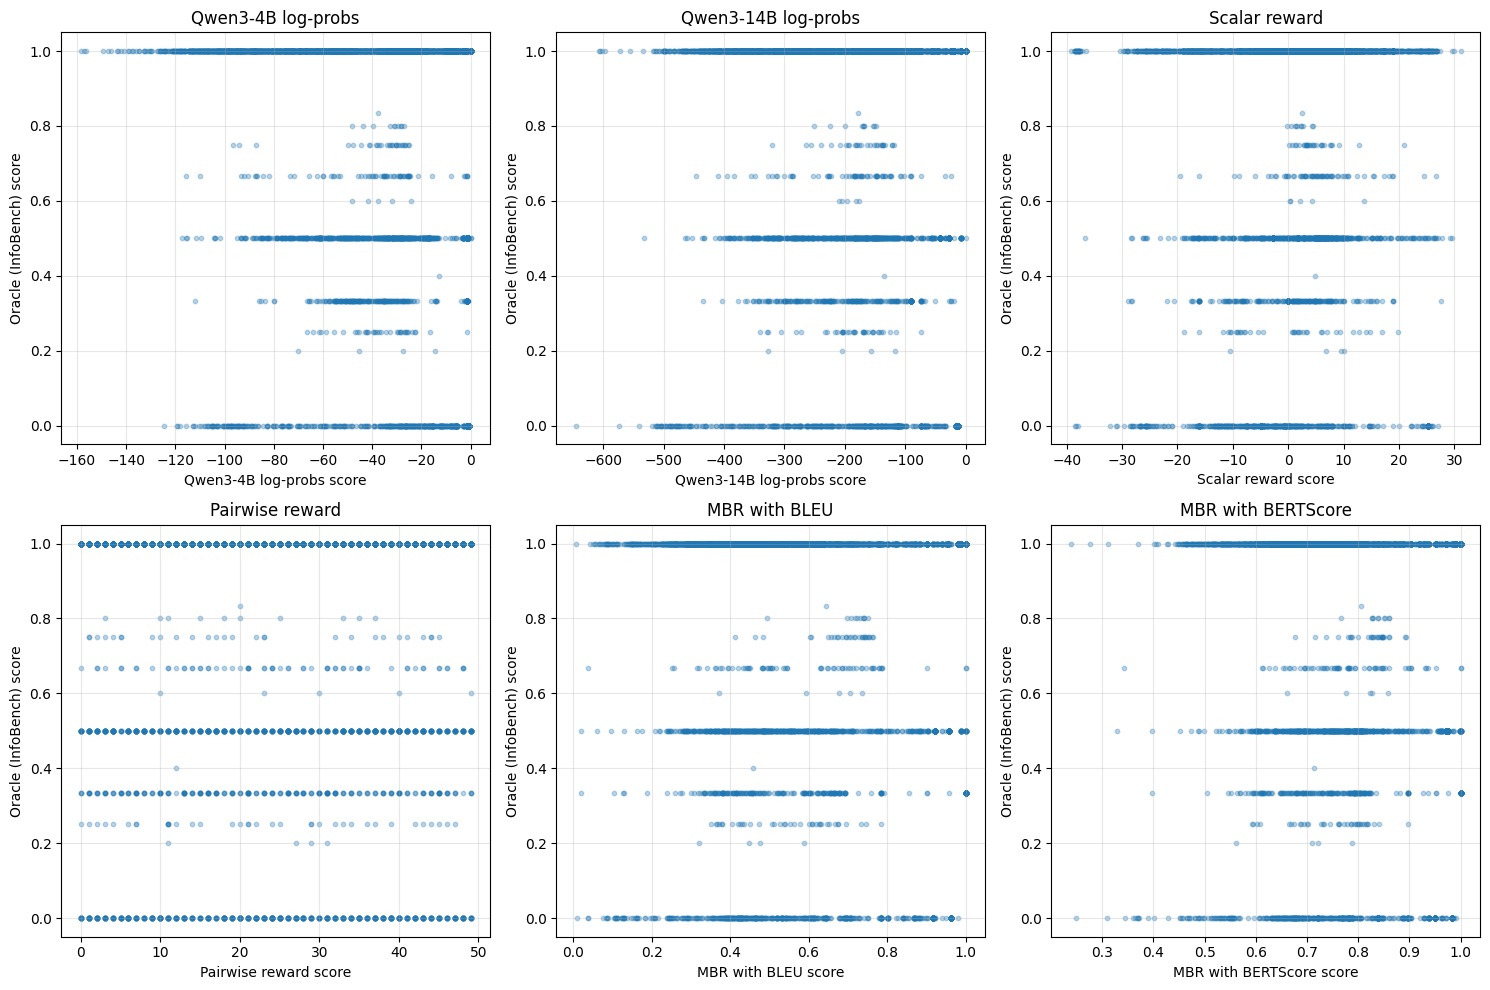

In [29]:
methods_to_plot = {
    'Qwen3-4B log-probs': 'qwen3_4b',
    'Qwen3-14B log-probs': 'qwen3_13b',
    'Scalar reward': 'r_scalar',
    'Pairwise reward': 'r_pairwise',
    'MBR with BLEU': 'mbr_bleu',
    'MBR with BERTScore': 'mbr_bert',
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method_name, score_name) in enumerate(methods_to_plot.items()):
    ax = axes[idx]
    
    # Collect all scores
    method_scores = []
    oracle_scores = []
    
    for result in all_results['results']:
        for candidate in result['candidates']:
            method_score = candidate['scores'][score_name]
            oracle_score = candidate['scores']['infobench']
            
            if method_score is not None:
                method_scores.append(method_score)
                oracle_scores.append(oracle_score)
    
    # Create scatter plot
    ax.scatter(method_scores, oracle_scores, alpha=0.3, s=10)
    ax.set_xlabel(f'{method_name} score')
    ax.set_ylabel('Oracle (InfoBench) score')
    ax.set_title(method_name)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('score_correlations.pdf', bbox_inches='tight')
plt.show()

In [8]:
n_values = [5, 10, 20]
all_n_results = {}

for n in n_values:
    filename = f'all_results_n{n}.json'
    print(f"Loading {filename}...")
    with open(filename, 'r') as f:
        all_n_results[n] = json.load(f)

for n in n_values:
    print(f"\n{'='*80}")
    print(f"Results for n={n} candidates")
    print(f"{'='*80}")
    
    print(f"{'Method':<25} {'Top-1 score':<15} {'Avg. rank':<15} {'Spearman':<15}")
    print("="*70)
    
    for method_name, score_name in methods.items():
        top1, avg_rank, spearman = compute_metrics(all_n_results[n], score_name)
        print(f"{method_name:<25} {top1:<15.4f} {avg_rank:<15.2f} {spearman:<15.4f}")

Loading all_results_n5.json...
Loading all_results_n10.json...
Loading all_results_n20.json...

Results for n=5 candidates
Method                    Top-1 score     Avg. rank       Spearman       
Oracle                    0.8883          1.00            1.0000         
Qwen3-4B log-probs        0.7108          1.42            0.0780         
Qwen3-14B log-probs       0.7475          1.38            0.0580         
Scalar reward             0.7258          1.34            0.1190         
Pairwise reward           0.7642          1.32            0.0410         
MBR with BLEU             0.7480          1.37            0.0770         
MBR with BERTScore        0.7525          1.40            0.0830         

Results for n=10 candidates
Method                    Top-1 score     Avg. rank       Spearman       
Oracle                    0.9533          1.00            1.0000         
Qwen3-4B log-probs        0.7167          1.87            0.0202         
Qwen3-14B log-probs       0.7800  